<a href="https://colab.research.google.com/github/Chris-Manna/charity_recommender/blob/master/recommend_charities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtain The Data

#### Access Google Drive Files

In [1]:
### Connect personal Google drive to local Google Colabs
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

#getting the right files in place
import zipfile
from os import listdir
from os.path import isfile, join

# ensuring we get the same results in randomized selections
np.random.seed(1)

# plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot#, iplot

    100% |████████████████████████████████| 993kB 19.3MB/s 


In [0]:
### Clean up
%cd data/CSVs

# %cd ../../
# !pwd
# %rm -rf './data'

[Errno 2] No such file or directory: 'data/CSVs'
/content


#### Creating Directories, Loading Documents into Local Colabs Drive

In [2]:
# # Access data from Local Colab Drive
!mkdir data
!mkdir data/zipfiles
!mkdir data/CSVs
%cd data/zipfiles

# https://www.kaggle.com/donorschoose/io#Resources.csv

donors_id = '1e-4Lu8werRUdqeFzpM7cOL3vZ4gA7xh6'
donations_id = '1GwzrUxOXduYRdx_qWNwjD7bJbksjEeeE'
projects_id = '1OJXbjFo1tc3yn3SfDgq1Rk9HvAvKQ8O8'
resources_id = '1A1EOiSF9kUWImCILRFZl9-zLgArtBDed'
schools_id = '1W95AOCTg6kKj5nZTCUKaas668N9RcZ2U'
teachers_id = '1W0pfHkFss8hJ5TGP_tyF2Vv-ubxX2FCd'

zip_file_ids = [donors_id,
                donations_id,
                projects_id,
                resources_id,
                schools_id,
                teachers_id]

for file_id in zip_file_ids:
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(downloaded['title'])
  
%cd ../CSVs/
!unzip ../zipfiles/Donations.csv.zip
!unzip ../zipfiles/Donors.csv.zip
!unzip ../zipfiles/Projects.csv.zip
!unzip ../zipfiles/Resources.csv.zip
!unzip ../zipfiles/Schools.csv.zip
!unzip ../zipfiles/Teachers.csv.zip
!ls
%cd ./data/CSVs
!pip install scikit-surprise

/content/data/zipfiles
/content/data/CSVs
Archive:  ../zipfiles/Donations.csv.zip
  inflating: Donations.csv           
Archive:  ../zipfiles/Donors.csv.zip
  inflating: Donors.csv              
Archive:  ../zipfiles/Projects.csv.zip
  inflating: Projects.csv            
Archive:  ../zipfiles/Resources.csv.zip
  inflating: Resources.csv           
Archive:  ../zipfiles/Schools.csv.zip
  inflating: Schools.csv             
Archive:  ../zipfiles/Teachers.csv.zip
  inflating: Teachers.csv            
Donations.csv  Projects.csv   Schools.csv
Donors.csv     Resources.csv  Teachers.csv
[Errno 2] No such file or directory: './data/CSVs'
/content/data/CSVs
    100% |████████████████████████████████| 3.3MB 9.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


#### Get all content of files from CSVs folder

In [3]:
donations_data = pd.read_csv('Donations.csv')
donors_data = pd.read_csv('Donors.csv')
projects_data = pd.read_csv('Projects.csv')
# resources_data = pd.read_csv('Resources.csv')
# schools_data = pd.read_csv('Schools.csv')
# teachers_data= pd.read_csv('Teachers.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



# Explore Data
---
Total US DataSet:
- Total Amount Received over 5 year period: $284,408,243.28

- More Recent Date Donation Received: 2018-05-09

- Earliest Data Donation Received: 2012-10-08

- Max Single Donation: $60,000.00

- Min Single Doation: $0.01

- Total # of Donations: 4,687,884

- Most Frequent Donor Donated 18,035 times and donated $1,879,624.97 over a five year period. This might be coming from one group of people using the same account?
----

New York State:

- Total Amount Received over a 5 year period: $24,532,648.52

- Total Number of Donations Received from NY: 355,926 

- Most Recent Date Donation Received: 2018-05-09

- Earliest Date Donation Received: 2012-10-08

- The most common donor donated 10,515 times 

- Max Single Donation: $20,000.00

- Min Single Donation: $0.08
---
New York City:

- Total Amount Received over a 5 year period: $8,015,266.39

- Total Number of Donations Received from NYC: 76,257 donations

- Most Recent Date Donation Received: 2018-05-09

- Earliest Date Donation Received: 2012-10-27

- The most common donor donated 2,152 times 

- Max Single Donation: $19,588.38

- Min Single Donation: $0.21


In [0]:
donors_donations_df = pd.DataFrame(donors_data.merge(donations_data,on='Donor ID'))
total_donations = donations_data['Donation Amount'].sum()

In [71]:
# ny_state_donors = donors_donations_df.loc[donors_donations_df['Donor State'] == 'New York'] # 355,926 donations from NY
# ny_state_donors['Donation Amount'].sum()
# ny_state_donors['Donor ID'].value_counts()#['Donation Amount'].sum().max()

# nyc_donors = ny_state_donors.loc[ny_state_donors['Donor City'] == 'New York'] # 76257 donations from NYC
# nyc_donors['Donation Received Date'].min()
# nyc_donors['Donor ID'].value_counts().max()
# nyc_donors['Donation Amount'].sum() # $8,015,266.39
# nyc_donors['Donor ID'].nunique() # 26,009 unique donors
# len(nyc_donors['Donation Amount']) # 76,257 donations
# averaging $104.91 per donation and $308.17 per donor
nyc_donors['Donation Amount'].max()

# nyc_donor_totals = pd.DataFrame(nyc_donors.groupby('Donor ID')['Donation Amount'].sum()) # Group by a single donor in NYC
# # nyc_donor_totals[['Donation Amount']].max() # Single Donor Total Maximum Contribution: $1,243,529.69
# # nyc_donor_totals[['Donation Amount']].min() # Single Donor Total Minimum Contribution: $1.00


19588.38

In [0]:
# nyc_donor_totals.sort_values(by='Donation Amount')

In [0]:
nyc_quartiles = nyc_donor_totals[['Donation Amount']].quantile([0,0.25,0.5,0.75,1])

In [73]:
nyc_donor_totals[['Donation Amount']].transform(np.log,axis=0).mean()

Donation Amount    4.218604
dtype: float64

In [74]:
nyc_quartiles.transform(np.log,axis=0)

,Donation Amount
0.00,0.000000
0.25,3.218876
0.50,3.912023
0.75,4.724286
1.00,14.033464


In [0]:
nyc_donor_totals = pd.DataFrame(nyc_donors.groupby('Donor ID')['Donation Amount'].sum())
# nyc_donor_totals_plt = nyc_donor_totals.sort_values(by='Donation Amount', ascending=True)
# nyc_donor_totals_plt.plot(figsize=(12,8),title='Donor Amount Measured in Log',logy=True)
# get_yticks([1,10,100,1000,10000,100000,100000])

In [0]:
median_nyc_donation = list(nyc_donor_totals.median())[0]
mean_nyc_donation = list(nyc_donor_totals.mean())[0]

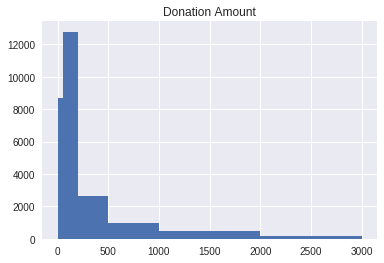

In [77]:
donation_count = nyc_donor_totals.hist(bins=[0,50,200,500,1000,2000,3000])
# plt.title("Total Donations Amount, NYC")
# mean = plt.axvline(nyc_donor_totals['Donation Amount'].mean(), color='cyan', linestyle='dashed', linewidth=1)
# median = plt.axvline(nyc_donor_totals['Donation Amount'].median(), color='white', linestyle='dashed', linewidth=1)
# plt.legend((mean,median),("Mean %s" %(round(mean_nyc_donation,2)),"Median %s" %(round(median_nyc_donation,2))))
# plt.show()

In [0]:
# nyc_donor_totals.head()#.value_counts()

In [0]:
# nyc_donors.head()

# Donors

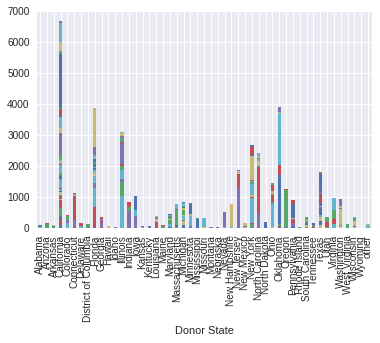

In [80]:
data_1000cs = donors_donations_df[['Donor State','Donor City','Donation Amount']][:1000]
data_1000sc_sum = data_1000cs.set_index(['Donor State','Donor City']).groupby(level=[0, 1]).sum()
data_1000sc_sum.nlargest(10,columns='Donation Amount').sort_values(by='Donation Amount',ascending=False,inplace=True)

data_1000sc_sum.unstack().plot(kind='bar', stacked=True).get_legend().remove()

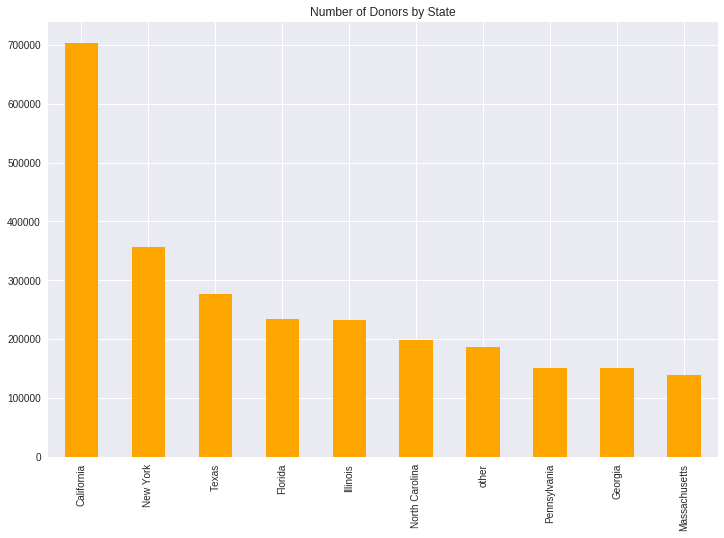

In [81]:
temp = donors_donations_df["Donor State"].value_counts().head(10)
temp.plot(kind='bar', title = 'Number of Donors by State',color='orange',figsize=(12,8))

In [82]:
len(list(donors_donations_df["Donor State"].value_counts()))


52

In [0]:
# donors_donations_df["Donation Amount"].sum()

In [83]:
donors_donations_df["Donor State"]

0                      Illinois
1                         other
2                    California
3                    California
4                    California
5                    California
6                    California
7                    California
8                    California
9                    California
10                   California
11                   California
12                   California
13                      Indiana
14                      Indiana
15                      Indiana
16                      Indiana
17                      Indiana
18                   New Jersey
19                        other
20                  Connecticut
21                    Wisconsin
22                     New York
23                      Indiana
24                      Indiana
25                 Pennsylvania
26                 Pennsylvania
27                   New Jersey
28                   New Jersey
29                   New Jersey
                   ...         
4681870 

In [0]:
list(temp.keys())

['California',
 'New York',
 'Texas',
 'Florida',
 'Illinois',
 'North Carolina',
 'other',
 'Pennsylvania',
 'Georgia',
 'Massachusetts']

In [0]:
(0,) * len(list(temp))

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [0]:
list(temp)

[704025,
 355926,
 276130,
 234475,
 233169,
 198032,
 185952,
 151223,
 150805,
 138538]

([<matplotlib.patches.Wedge at 0x7f06305d8cf8>,
 [Text(2.969819663514787, 1.6553462375590557, 'New Mexico'),
  Text(0.16798518641800556, 3.3958476080566555, 'Hawaii'),
  Text(-2.673788459369621, 2.100203626923311, 'West Virginia'),
  Text(-3.3762462513089773, -0.40119976386094885, 'Nebraska'),
  Text(-2.4256796949250092, -2.3824521018539944, 'Alaska'),
  Text(-0.5076068513701574, -3.361894597461687, 'Montana'),
  Text(1.3555961213649352, -3.118069780447568, 'South Dakota'),
  Text(2.586486262544076, -2.2068277716375553, 'Vermont'),
  Text(3.192947225676171, -1.1683698104824705, 'North Dakota'),
  Text(3.381263427499307, -0.35645144670156625, 'Wyoming')])

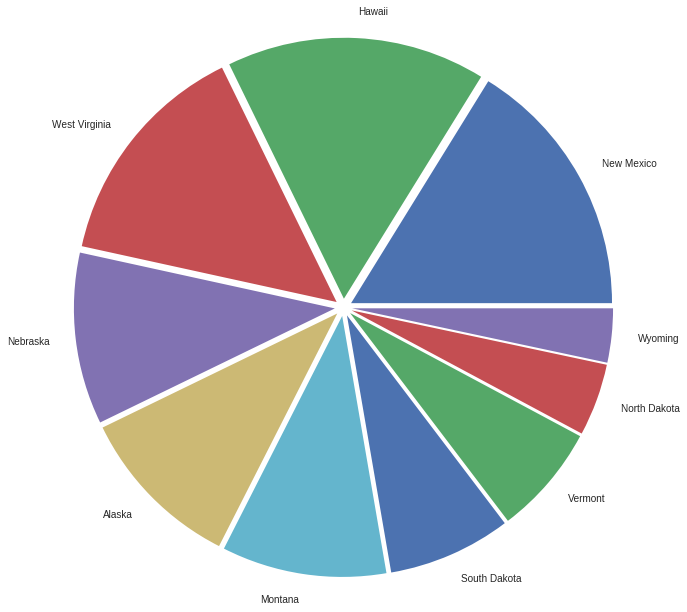

In [0]:
plt.pie(temp,radius=3,labels=list(temp.keys()),frame=False,explode=((0.1,) * len(list(temp))))

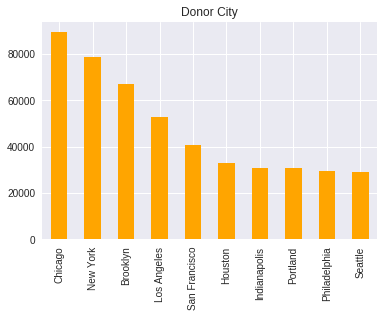

In [0]:
temp = donors_donations_df["Donor City"].value_counts().head(10)
temp.plot(kind='bar', title = 'Donor City',color='orange')

In [0]:
# list(donors_donations_df["Donor City"].value_counts().head(10000))

In [0]:
donors_donations_df[['Donor State','Donor City','Donation Amount']][:1000]

,Donor State,Donor City,Donation Amount
0,Illinois,Evanston,50.00
1,other,Appomattox,99.00
2,California,Winton,26.00
3,California,Winton,100.00
4,California,Winton,13.75
5,California,Winton,100.00
6,California,Winton,100.00
7,California,Winton,100.00
8,California,Winton,9.69
9,California,Winton,150.00


In [0]:
top_ten

NameError: ignored

In [0]:
nyc_donors.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date
153,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,1e10246b6c98fd9928ecb9bf8a57c421,c4dbf0c6b7aecfacdf4f74b67d2ab3ca,Yes,50.0,1,2013-09-06 10:40:22
154,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,63c323ec98fadda04347847416c19a8c,59b268e17a2e21a71f64a8088357abf7,Yes,50.0,2,2015-05-19 12:53:00
155,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,80bbb681713c37970a4f70faa5d54cf4,8ad992723b3ade2c4f776dd5c5b6232a,Yes,250.0,3,2016-02-17 10:50:18
156,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,e00ad9791896490d45d91a3c00cd6e79,0d182a5eaa45273d7b227725a852d329,Yes,100.0,4,2016-09-08 20:41:49
418,0005ffefbb56fc35b8627c73c4c1c6fc,New York,New York,No,100,68c73a9f47ca6971e8bb246e99b521df,3079cb9276cb997ccbef75f9e531e9bd,Yes,50.0,1,2016-08-17 11:12:15


KeyboardInterrupt: ignored

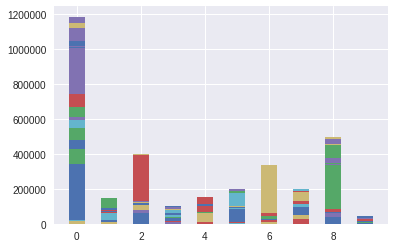

In [0]:
data_cs = donors_donations_df[['Donor State','Donor City','Donation Amount']]
top_ten = data_cs.loc[data_cs['Donor State'].isin(['California','New York','Texas','Florida','Illinois','North Carolina','other','Pennsylvania','Georgia','Massachusetts'])]
top_ten_sum = top_ten.set_index(['Donor State','Donor City']).groupby(level=[0, 1]).sum()

top_ten_sum.unstack().plot(kind='bar', stacked=True).get_legend().remove()

In [0]:
data_1000cs = top_ten[['Donor State','Donor City','Donation Amount']]
data_1000sc_sum = data_1000cs.set_index(['Donor State','Donor City']).groupby(level=[0, 1]).sum()
data_1000sc_sum.nlargest(10,columns='Donation Amount').sort_values(by='Donation Amount',ascending=False,inplace=True)

# data_1000sc_sum.unstack().plot(kind='bar', stacked=True).get_legend().remove()

NameError: ignored

KeyboardInterrupt: ignored

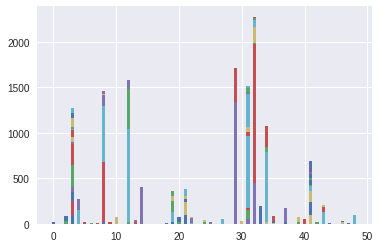

In [0]:
data_1000cs = donors_donations_df[['Donor State','Donor City','Donation Amount']][:1000]
data_1000sc_sum = data_1000cs.set_index(['Donor State','Donor City']).groupby(level=[0, 1]).sum()
data_1000sc_sum.nlargest(10,columns='Donation Amount').sort_values(by='Donation Amount',ascending=False,inplace=True)

data_1000sc_sum.unstack().plot(kind='bar', stacked=True).get_legend().remove()

#### Combine Pandas DataFrames

In [0]:
projects_donations = projects_data.merge(donations_data, on='Project ID')
# projects_donations.columns

In [0]:
donors_data.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953
3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462
4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075


In [0]:
data_df = donors_data.merge(projects_donations[['Donor ID','Project ID','Project Title','Project Type','Donation Amount']], on='Donor ID')
data_df.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Project Title,Project Type,Donation Amount
0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602,5bab6101eed588c396a59f6bd64274b6,Projecting the World in One Unique Classroom,Teacher-Led,50.00
1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245,9db61b1b1e43a7b256eec9b20b42d854,Small Town Dreams: Legislating in the Commonwe...,Student-Led,99.00
2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f7996f08052785e9b146f72c0c4990d,Bring Robotics to Our Library Makerspace!,Teacher-Led,13.75
3,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,dfdaf35bb33f9c105530c82984960ff3,"If It Ain't BAROQUE, Don't Fix It: Baroque-Fin...",Teacher-Led,9.69
4,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,e2beb818569f66adaa4ced21ca299ac6,Discover a New World With Books,Teacher-Led,10.00


In [0]:
nyc_project_donations = nyc_donors.merge(projects_data[['Project ID','Project Title','Project Type']], on='Project ID')
# nyc_project_donations.head()

#### Append binary column for donated

In [0]:
def f(row):
  if isinstance(row['Donation Amount'],float) and row['Donation Amount'] > 0:
    return 1
  else:
    return 0

# isinstance(data_df['Donation Amount'][1],int)
# data_df['Donated'] = data_df.apply(f, axis=1)
# data_df.head(100)

In [0]:
nyc_project_donations.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,Project Title,Project Type
0,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,1e10246b6c98fd9928ecb9bf8a57c421,c4dbf0c6b7aecfacdf4f74b67d2ab3ca,Yes,50.0,1,2013-09-06 10:40:22,Mapping To Save The Planet,Teacher-Led
1,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,63c323ec98fadda04347847416c19a8c,59b268e17a2e21a71f64a8088357abf7,Yes,50.0,2,2015-05-19 12:53:00,Camping Supplies,Teacher-Led
2,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,80bbb681713c37970a4f70faa5d54cf4,8ad992723b3ade2c4f776dd5c5b6232a,Yes,250.0,3,2016-02-17 10:50:18,Science Computers and Programming Innovation,Teacher-Led
3,00019e1dcd80085636a622f27c5b1233,New York,New York,No,100,e00ad9791896490d45d91a3c00cd6e79,0d182a5eaa45273d7b227725a852d329,Yes,100.0,4,2016-09-08 20:41:49,Body Systems Frankenstein Project Supplies,Teacher-Led
4,0005ffefbb56fc35b8627c73c4c1c6fc,New York,New York,No,100,68c73a9f47ca6971e8bb246e99b521df,3079cb9276cb997ccbef75f9e531e9bd,Yes,50.0,1,2016-08-17 11:12:15,"With a Small Group Table, We Can Learn Together!",Teacher-Led


In [0]:
# nyc_project_donations['Project Type'].value_counts().plot()
# plt.pie(nyc_project_donations['Donor Is Teacher'].value_counts(),radius=3,labels=['Yes','No'],frame=False,explode=((0.1,0.1)),autopct=True)

In [0]:
nyc_projects_3 = nyc_project_donations[['Donor ID','Project Title','Donation Amount']]

In [0]:
nyc_projects_3['Donated'] = nyc_projects_3.apply(f,axis=1)
nyc_projects_3.drop(columns='Donation Amount',inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [0]:
len(nyc_projects_3['Project Title'])

75676

## Using Surprise

In [0]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise import SVDpp
from surprise import SVD
from surprise import NMF
from surprise import CoClustering
from surprise import model_selection

# we want to use the neighborhood method (KNN)
# - if you have to recommend items to a given user, 
#   try to find people that have the same taste as the user 

#### Binarizing NYC Utility Matrix

In [0]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0, 1))

In [0]:
data = Dataset.load_from_df(nyc_projects_3[['Donor ID','Project Title','Donated']], reader)
trainset = data.build_full_trainset()

In [0]:
# param_grid = {'k': [10, 20],
#               'sim_options': {'name': ['msd', 'cosine'],
#                               'min_support': [1, 5],
#                               'user_based': [False]}
#               }

In [0]:
# cross_validate(algo_svd, data, measures=[u'rmse', u'mae'], verbose=1)
# could not use 'fcp' because every user must have at least two predictions and there are instances where users only have one charity donation

In [0]:
algos = [SVD(),SVDpp(),NMF(),CoClustering(),NormalPredictor()]

for algo in algos:
  print(cross_validate(algo,data, measures=[u'rmse', u'mae'], verbose=1))
  print('\n\n')

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0345  0.0341  0.0327  0.0334  0.0329  0.0335  0.0007  
MAE (testset)     0.0123  0.0125  0.0119  0.0120  0.0119  0.0121  0.0002  
Fit time          5.03    4.85    4.81    4.80    4.83    4.86    0.08    
Test time         0.14    0.13    0.27    0.13    0.13    0.16    0.05    
{'test_rmse': array([0.03446423, 0.03405514, 0.03270281, 0.03342321, 0.03290554]), 'test_mae': array([0.01226032, 0.01249155, 0.01186511, 0.01204237, 0.01186961]), 'fit_time': (5.026256561279297, 4.845373153686523, 4.813767433166504, 4.8039021492004395, 4.829265832901001), 'test_time': (0.1383805274963379, 0.12766218185424805, 0.265946626663208, 0.1293048858642578, 0.1283886432647705)}



Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0203  0.0208  0.0200  0.0206

In [0]:
print('SVD++')
algo_svdpp = SVDpp()

algo_svdpp.fit(trainset)
print(algo_svdpp.predict('00019e1dcd80085636a622f27c5b1233','Mapping To Save The Planet'))
print(algo_svdpp.predict('00019e1dcd80085636a622f27c5b1233','Camping Supplies'))
print('\n')

SVD++
user: 00019e1dcd80085636a622f27c5b1233 item: Mapping To Save The Planet r_ui = None   est = 0.99   {'was_impossible': False}
user: 00019e1dcd80085636a622f27c5b1233 item: Camping Supplies r_ui = None   est = 1.00   {'was_impossible': False}




# Recommender Systems for users
https://surprise.readthedocs.io/en/stable/FAQ.html

## Predicting User Single Donation

Return charities a single donor would be most likely to donate to

Donors are similar to users or customers of a online platform providing various products. 
Recommend more items based on customer a's history and the history of other customers who are similar to customer a

Once donor a donates to one or more projects at DonorsChoose.org, 
We will be able to recommend more projects to her based on her donation history and the donation history of other donors who are similar to her

**Content-Based Filtering:** This method uses only information about the description and attributes of the projects donors has previously donated to when modeling the donor's preferences. In other words, these algorithms try to recommend projects that are similar to those that a donor has donated to in the past. In particular, various candidate projects are compared with projects the donor has donated to, and the best-matching projects will be recommended.

**Collaborative Filtering:** This method makes automatic predictions (filtering) about the preference of a donor by collecting preferences from many other donors (collaborating). It predicts what a particular donor will donate to based on what projects other similar donors have donated to. The underlying assumption of the collaborative filtering approach is that if Alice and Bob have donated to the same project(s), Alice is more likely to share Bob's preference for a given project than that of a randomly chosen donor.

**Hybrid methods:** Most companies like Netflix and Hulu use a hybrid approach in their recommendation models, which provide recommendation based on the combination of what content a user like in the past as well as what other similar user like. Recent research has demonstrated that a hybrid approach that combines collaborative filtering and content-based filtering could be more effective than both approaches in some cases. These hybrid methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

## Getting the top-N recommendations 
 - Get the top-10 items with highest rating prediction for each user.
 - First train an SVD algorithm on the whole dataset,
 - Then predict all the ratings for the pairs (user, item) that are not in the training set.
 ? What is training set? 

In [0]:
# Import libraries
from collections import defaultdict

from surprise import SVD
from surprise import SVDpp
from surprise import Dataset

In [0]:
data_1000 = nyc_projects_3[['Donor ID','Project Title','Donated']].head(1000)

In [0]:
data_1000.head()

,Donor ID,Project Title,Donated
0,00019e1dcd80085636a622f27c5b1233,Mapping To Save The Planet,1
1,00019e1dcd80085636a622f27c5b1233,Camping Supplies,1
2,00019e1dcd80085636a622f27c5b1233,Science Computers and Programming Innovation,1
3,00019e1dcd80085636a622f27c5b1233,Body Systems Frankenstein Project Supplies,1
4,0005ffefbb56fc35b8627c73c4c1c6fc,"With a Small Group Table, We Can Learn Together!",1


With what certainty are each of these recommednations made? 

Has the user already made a charitable contribution?

In [0]:
# All the ratings returned are a 1
# - does that mean it's 100% certain the user will want to donate?

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
#         print(true_r)

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def give_recs(uid, df):
  
  # First train an algorithm on the dataset.
  data = Dataset.load_from_df(df, reader)
  trainset = data.build_full_trainset()

#   algo = SVDpp(random_state=3)
  algo = NMF(random_state=3)
  algo.fit(trainset)

  # Then predict ratings for all pairs (u, i) that are NOT in the training set.
  testset = trainset.build_anti_testset()
  predictions = algo.test(testset)

  top_n = get_top_n(predictions, n=10)
  return top_n[uid]

In [0]:
  # First train an algorithm on the dataset.
  data = Dataset.load_from_df(data_1000, reader)
  trainset = data.build_full_trainset()

  algo = SVDpp(random_state=3)
#   algo = NMF(random_state=3)
  # algo = CoClustering()
  # algo = SVD()
  # algo = NormalPredictor()
  algo.fit(trainset)

  # Then predict ratings for all pairs (u, i) that are NOT in the training set.
  testset = trainset.build_anti_testset()
  predictions = algo.test(testset)
  predictions

  top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
  for uid, user_ratings in top_n.items():
      print(uid, [iid for (iid, _) in user_ratings])

00019e1dcd80085636a622f27c5b1233 ['Students Helping Students', 'A 3D Classroom', 'Be a "Bucket Filler" Donate Prizes!', "Chromebooks for Harlem's Brightest  ", '"Oh, the Places You\'ll Go..." With Technology! (2)', 'Yoga Mats for Awesome Kids', 'Keep Calm and Crochet On!', 'Finding Books That Are "Just Right"', 'Kindle Saves the Day!', 'Motivation Station: No Hangry Child Left Behind']
0005ffefbb56fc35b8627c73c4c1c6fc ['Camping Supplies ', 'Science Computers and Programming Innovation', 'Rocking The Bronx: Bringing Music To The Classroom', 'Flipped Classroom Start-Up', 'Be a "Bucket Filler" Donate Prizes!', "Slimmer's Seat Pockets", 'Class Trip Project: Washington DC', '"Oh, the Places You\'ll Go..." With Technology! (2)', 'Help Us Achieve The Common Core', 'Spring Art Show Materials']
14dd2ccecad07d00c95d7594d6b45683 ['Camping Supplies ', 'Body Systems Frankenstein Project Supplies', '1st Grade Math Center: Putting Things in Order', 'Students Helping Students', 'Rocking The Bronx: Bri

In [0]:
charity_arr = []

In [0]:
project_ids = list(set(data_1000['Project Title']))

In [0]:
project_ids

['The Future of the World Is in My Classroom Today...',
 'Science Alive!',
 'Technology In The Classroom!',
 'Have You READ Any MATH Lately?',
 'Help Support the "Ball" Chairs!',
 'Mapping To Save The Planet',
 'iPads to Inspire, Engage, and Ignite Young Inquisitors!',
 'Project History to Reach Success!',
 'Getting "In the Spirit"',
 'iPad for Differentiation',
 'We are Smart, Smart, Smart!',
 'Help Bronx Students Back to School With These Books!',
 'Please Help Us Get Along!',
 'College Ready with Chromebooks!',
 'Finding Books That Are "Just Right"',
 'Practicing Like a Professional',
 'Building Literacy with To Kill a Mockingbird',
 'Help Us Learn in First Grade!',
 'Tablets for our Future!',
 'To Learn to Read is to Light a Fire',
 'iLearn & iCreate With An iPad!',
 'Develop Fine Motor Skills',
 'Aidez-nous! We Need French Literacy Materials!',
 'Books to Change Young Lives',
 'Get (Kindle) FIREd Up About Reading!',
 'Creating a Community of Readers: On a Rug.',
 'Sophomore Campin

In [0]:
#@title #Charity Recommender<br><br>

#@markdown 1. Type 'CLEAR' before your first time using Charity Recommender
#@markdown 2. Write your name in so taht we can track your input and tune the recommender
#@markdown 3. Copy a charity from above, remove the apostrophes and quotes <br><br><br>


name = 'JSON' #@param {type:"string"}
charity = "Providing Eye Exams and Glasses!" #@param {type:"string"}

if name == 'CLEAR':
  data_1000 = data_1000[['Donor ID','Project Title','Donated']]
  charity_arr = []
else:
  charity_arr.append(charity)
  new_frame = pd.DataFrame([[name,charity,1]], columns=['Donor ID','Project Title','Donated'])
  data_1000 = data_1000.append(new_frame)
  print('Charities you said you donated to:')
  for donated in list(set(charity_arr)):
    print(donated)

  print('\n\n')
  all_recs = give_recs(name,data_1000)
  print('Based on your past selections, you may also want to donate to...')
  print(all_recs)
#   for rec in all_recs:
#     print(rec[0])

Charities you said you donated to:
Providing Eye Exams and Glasses!
Original iPAD Dies - Class is Devastated!



Based on your past selections, you may also want to donate to...
[('Technology Needed!', 0.9043860254185838), ('Readers Read, Writers Write! We are Both!', 0.9029874567513707), ('Solve and Wipe, Dry Erase Math!', 0.8868456878355657), ('Seeing the World Through Their Eyes!', 0.8762152794347482), ('Bringing History to Life with Book Clubs!', 0.861482598704288), ("Bringing Color to the Campus - LaGuardia's Outside Garden ", 0.8606918568760067), ('Techologicaly Speaking', 0.8561745335519246), ('Snacks For My Scholars!!!', 0.8445083059912737), ('Technologically Speaking, Take Two', 0.8355226879509681), ('Words, Image, and Sound: Literature and Art Through Technology', 0.832124825450351)]


In [0]:
new_frame.head()

,Donor ID,Project Title,Donated
0,Chris,YOUNG AUTHORS,1


In [0]:
algo.predict(new_frame)

TypeError: ignored

### Get tuning parameters

In [0]:
from surprise.model_selection import GridSearchCV

data = Dataset.load_from_df(data_df[['Donor ID','Project ID','Donated']].head(1000), reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gspp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

param_grid = {'n_epochs': [5, 10]}
gscc = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)
gspp.fit(data)
gscc.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
print(gspp.best_score['rmse'])
print(gscc.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
print(gspp.best_params['rmse'])
print(gscc.best_params['rmse'])

0.014409938051232965
0.012943792937745202
0.0
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}
{'n_epochs': 5}
